# Imports, styles, etc

In [1]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy
import glob
import re
import yaml
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

import scipy.stats as stats

filepaths = yaml.safe_load(open("../../config/filepaths.yaml"))

import sys
sys.path.append(filepaths['utils'])
from data import *
from liwc_utils import *
from analisys import *

In [2]:
plt.rcParams['axes.labelsize']  = 14 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.5

plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

In [8]:
DATASET = 'coraal-buckeye' # 'coraal-buckeye' | 'twitter' | 'youtube' | 'interview'

data = load_dataset(DATASET)
data.head(1)

,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,file,group
0,"text, mmhm, yes, um, ivory city northeast ivor...",0.046122,0.789697,0.375,0.0,0.000628,0.000439,0.000305,False,DCB_se1_ag4_f_01_1.txt,Black Woman


# Reading and processing data

In [9]:
#Numero de amostras de cada tipo
data.drop_duplicates('file').groupby('group').count()['text']

group
Black Man      70
Black Woman    72
White Man      19
White Woman    20
Name: text, dtype: int64

In [10]:
# Faz copia dos dados e remove qualquer caracter que não seja textual ou apóstrofo
df = data.copy()
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d'\s]+",'',x))

In [11]:
# executes a join in column text grouped by file, this will join all the texts and keep group info
text_df = df.groupby('file',as_index=False).agg({
    'text': lambda x: ' '.join(x),
    'group': lambda x: x.iloc[0]
})
text_df.head(3)

,file,text,group
0,ATL_se0_ag1_f_01_1.txt,text they talking about don't send him to his ...,Black Woman
1,ATL_se0_ag1_f_02_1.txt,text mary last time i checked yes i identify a...,Black Woman
2,ATL_se0_ag1_f_03_1.txt,text mary i'm black nineteenninety three brook...,Black Woman


In [12]:
liwc_parser = Liwc(filepaths['liwc_dict']) # carrega o dicionário e inicializa a classe do LIWC

text_df['liwc_count'] = text_df['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
text_df = text_df.reset_index(drop=True)
text_df.head(3)

,file,text,group,liwc_count
0,ATL_se0_ag1_f_01_1.txt,text they talking about don't send him to his ...,Black Woman,"{'function': 1241, 'pronoun': 473, 'ppron': 31..."
1,ATL_se0_ag1_f_02_1.txt,text mary last time i checked yes i identify a...,Black Woman,"{'relativ': 674, 'time': 191, 'function': 3001..."
2,ATL_se0_ag1_f_03_1.txt,text mary i'm black nineteenninety three brook...,Black Woman,"{'function': 1774, 'pronoun': 638, 'ppron': 43..."


---

# Processing data with LIWC

In [13]:
# create a new dataset where the dicts inside liwc_cont are expanded in columns
liwc_df = pd.concat([text_df.drop(['liwc_count'], axis=1), text_df['liwc_count'].apply(pd.Series)], axis=1)
liwc_df = liwc_df.fillna(0)

#normalizing 
liwc_df_norm = (liwc_df[liwc_parser.categories.values()].T * ( 1 / liwc_df[liwc_parser.categories.values()].sum(axis=1) )).T
liwc_df_norm.reset_index(drop=True,inplace=True)

liwc_df_norm['group'] = text_df['group']
liwc_df_norm = liwc_df_norm.fillna(0)
liwc_df_norm.head(3)

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,group
0,0.175233,0.066789,0.044761,0.021886,0.002542,0.009884,0.005366,0.005083,0.022028,0.010449,...,0.001977,0.000424,0.000282,0.017933,0.001271,0.003954,0.007484,0.004518,0.000000,Black Woman
1,0.178546,0.068598,0.040397,0.019871,0.003986,0.009043,0.005117,0.002380,0.027784,0.015469,...,0.000595,0.000654,0.000119,0.011304,0.002320,0.002737,0.003391,0.002618,0.000059,Black Woman
2,0.179828,0.064673,0.043791,0.027775,0.001014,0.008211,0.002838,0.003953,0.020781,0.014090,...,0.001521,0.000507,0.000101,0.018956,0.000203,0.003244,0.005677,0.009934,0.000000,Black Woman


---

## Kruscal-Wallis Test

In [14]:
experiments = []
old_experiments = []

for feature in liwc_parser.categories.values():
    
    result = stats.kruskal(
        liwc_df_norm[liwc_df_norm.group=='White Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='White Woman'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Woman'][feature],
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [15]:
import statsmodels.stats.multitest as smt
idx = smt.multipletests(pvals=experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(experiments[idx].sort_values('pvalue')))
experiments[idx].sort_values('pvalue')

25


,feature,statistic,pvalue
72,filler,83.267147,6.110411e-18
36,tentat,52.413508,2.444973e-11
49,affiliation,37.570959,3.483900e-08
30,female,36.771494,5.143159e-08
5,you,35.291215,1.057315e-07
2,ppron,32.292644,4.540531e-07
58,motion,31.722691,5.987220e-07
11,auxverb,30.987346,8.552792e-07
20,quant,30.776342,9.473949e-07
54,focuspast,30.647386,1.008500e-06


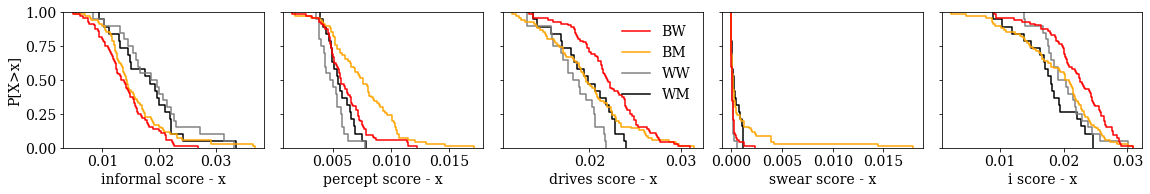

In [16]:
plot_liwc_features(liwc_df_norm, ploting_vars=['informal','percept','drives', 'swear', 'i'])

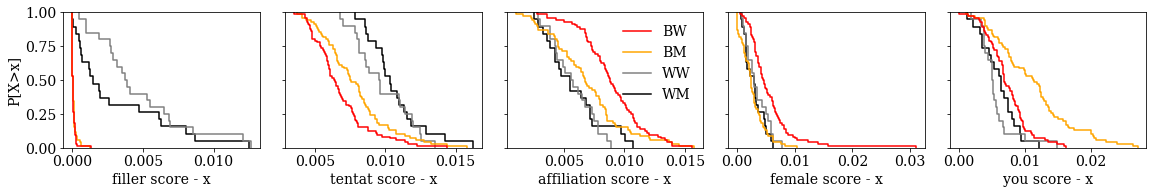

In [17]:
i = 0
ploting_vars = list(experiments.sort_values('pvalue').iloc[i:i+5].feature)

plot_liwc_features(liwc_df_norm,ploting_vars)

# individual categories analisys

### calculating liwc per sentence

In [18]:
scores_liwc = df.copy()

scores_liwc['liwc_count'] = scores_liwc['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
scores_liwc['len'] = scores_liwc.text.str.split(' ').str.len()
scores_liwc = scores_liwc.reset_index().rename(columns={'index':'sentence_id'})
scores_liwc = pd.concat([scores_liwc.drop(['liwc_count'], axis=1), scores_liwc['liwc_count'].apply(pd.Series)], axis=1)
scores_liwc = scores_liwc.fillna(0)
scores_liwc.head(1)

,sentence_id,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,...,negemo,sad,ingest,risk,feel,anx,anger,swear,filler,sexual
0,0,text mmhm yes um ivory city northeast ivory ci...,0.046122,0.789697,0.375,0.0,0.000628,0.000439,0.000305,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### KS test and bonferroni correction - For liwc categories scored

In [19]:
liwc_toxicity_experiments = []
for score in [col for col in scores_liwc.columns if 'score' in col]:
    for feature in liwc_parser.categories.values():
        if (len(scores_liwc[scores_liwc[feature]==0]) == 0 
                and len(scores_liwc[scores_liwc[feature]>0] == 0)):
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': np.nan,
                'pvalue': np.nan,
                'score': score
            })
        else:
            result = stats.ks_2samp(
                scores_liwc[scores_liwc[feature]==0][score],
                scores_liwc[scores_liwc[feature]>0][score]
            )
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': result[0],
                'pvalue': result[1],
                'score': score
            })

liwc_toxicity_experiments = pd.DataFrame(liwc_toxicity_experiments)
liwc_toxicity_experiments.sort_values('pvalue')

,feature,statistic,pvalue,score
0,function,0.459288,0.000000,perspective_score
336,body,0.428338,0.000000,detoxify_original_score
111,differ,0.206131,0.000000,flair_score
360,swear,0.854135,0.000000,detoxify_original_score
105,cogproc,0.165107,0.000000,flair_score
...,...,...,...,...
136,home,0.034706,0.000013,flair_score
402,certain,0.021999,0.000046,detoxify_unbiased_score
502,money,0.026935,0.009190,detoxify_multilingual_score
415,achiev,0.017650,0.021787,detoxify_unbiased_score


In [20]:
#seleciona as categorias em que todos scores são estatisticamente diferentes (p-value < 0.01)
#TODO: Bonferroni correction

relevant_categories_by_toxicity = liwc_toxicity_experiments.iloc[
    liwc_toxicity_experiments.groupby('feature').agg({
        'pvalue': lambda x: x.idxmax(),
    })['pvalue']
].query('pvalue < 0.01').feature.unique()

relevant_categories_by_toxicity

array(['adj', 'adverb', 'affect', 'affiliation', 'anger', 'anx',
       'article', 'assent', 'auxverb', 'bio', 'body', 'cause', 'certain',
       'cogproc', 'compare', 'conj', 'death', 'differ', 'discrep',
       'drives', 'family', 'feel', 'female', 'filler', 'focusfuture',
       'focuspast', 'focuspresent', 'friend', 'function', 'health',
       'hear', 'home', 'i', 'informal', 'ingest', 'insight', 'interrog',
       'ipron', 'leisure', 'male', 'money', 'motion', 'negate', 'negemo',
       'nonflu', 'number', 'percept', 'posemo', 'power', 'ppron', 'prep',
       'pronoun', 'quant', 'relativ', 'relig', 'reward', 'risk', 'sad',
       'see', 'sexual', 'shehe', 'social', 'space', 'swear', 'tentat',
       'they', 'time', 'verb', 'we', 'work', 'you'], dtype=object)

---
# Associating categories frequencies with toxicity

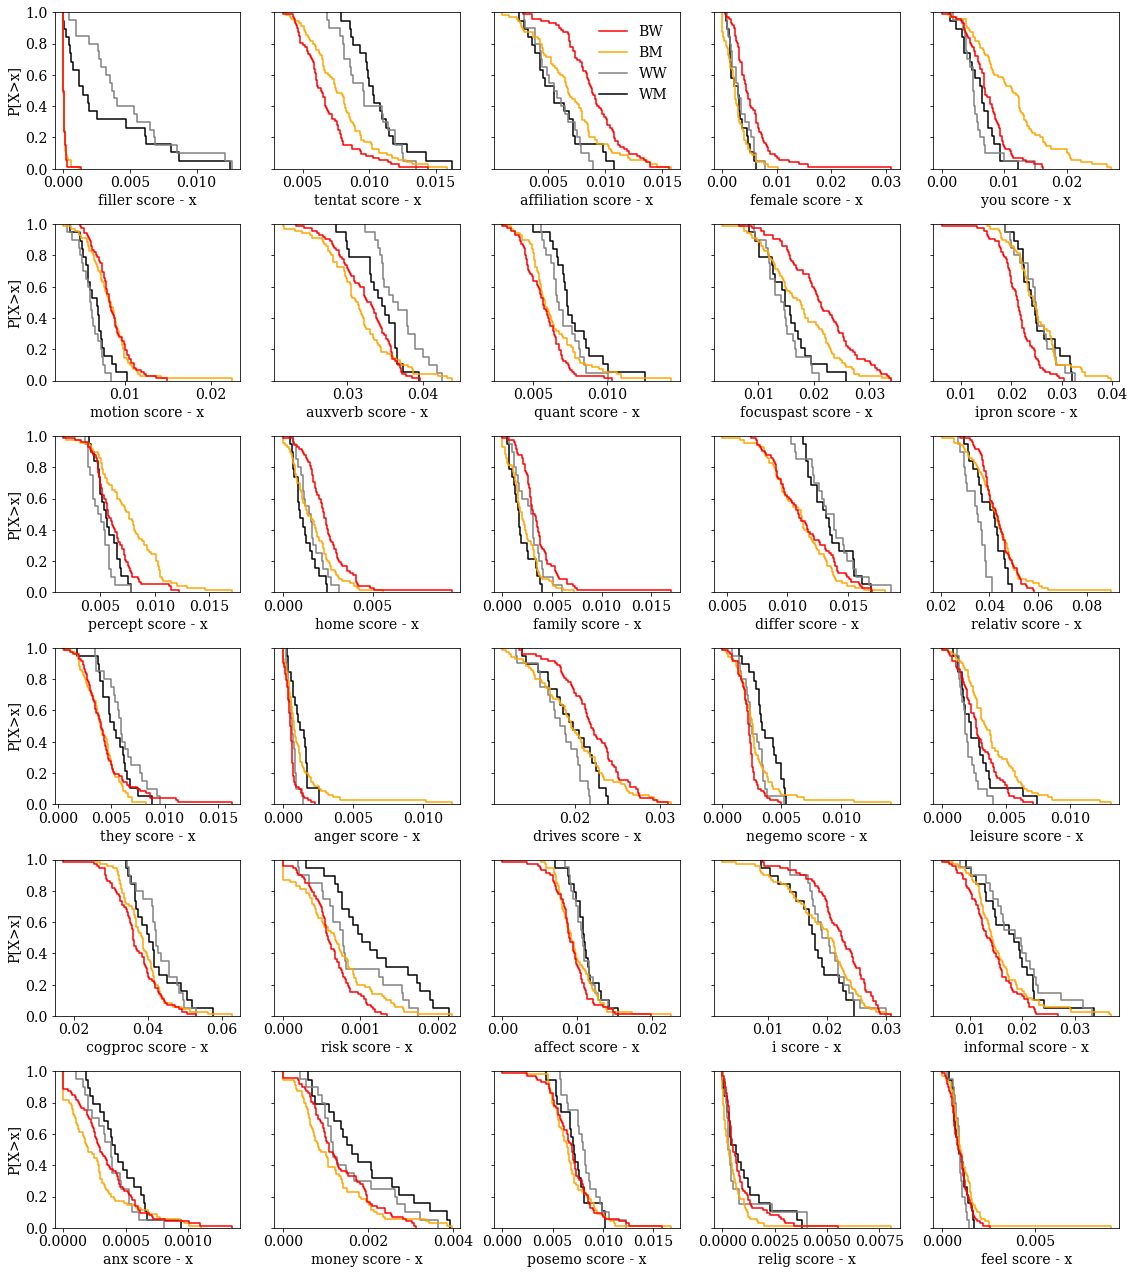

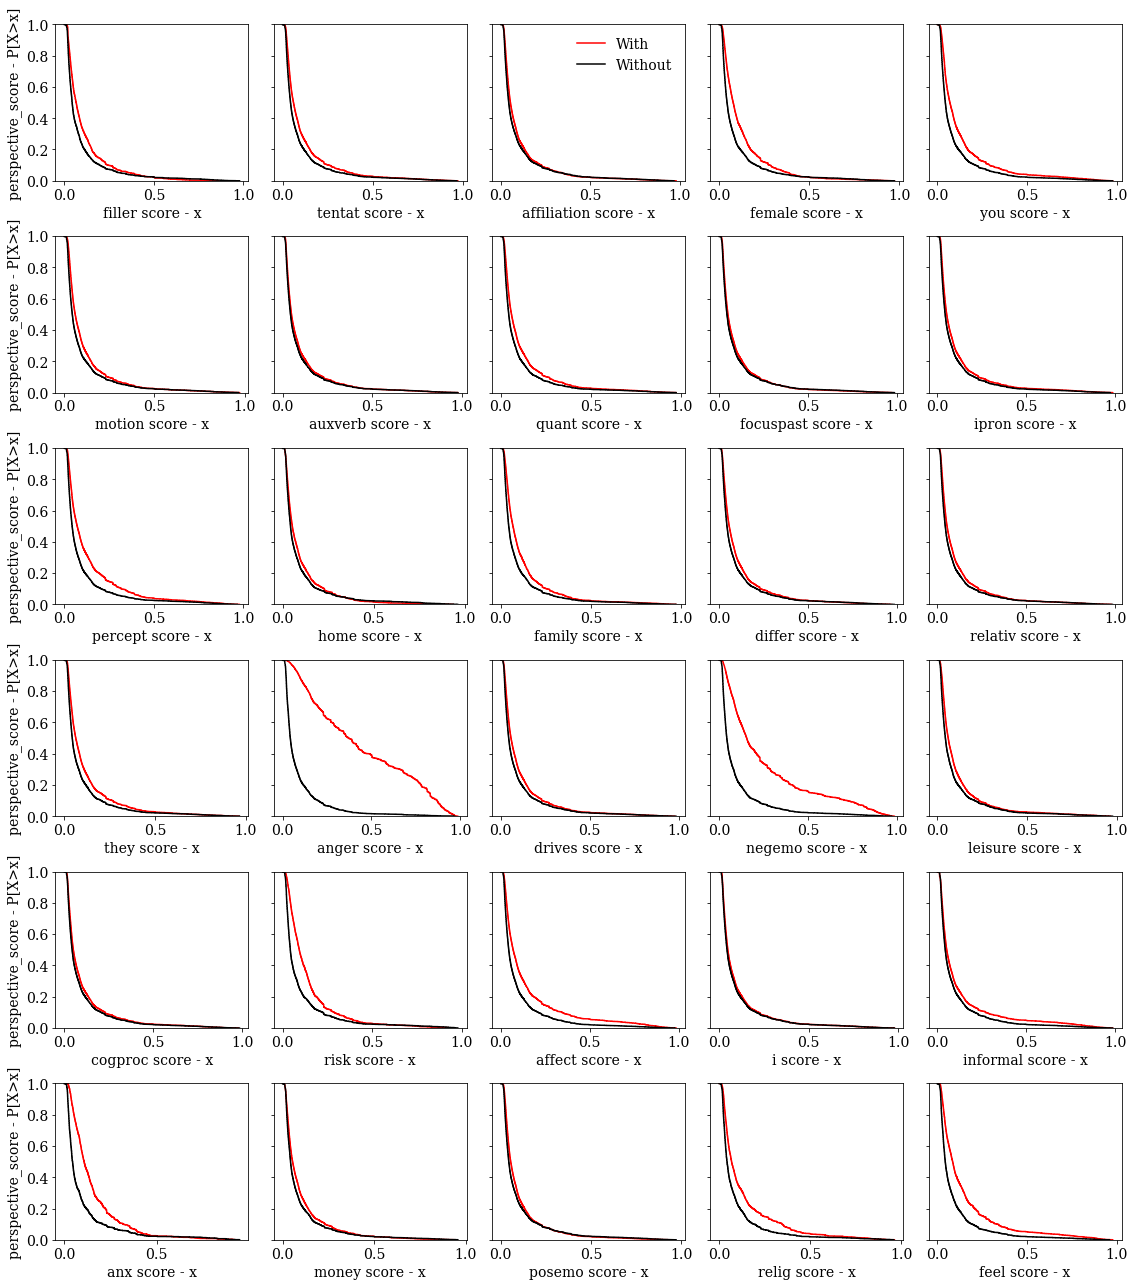

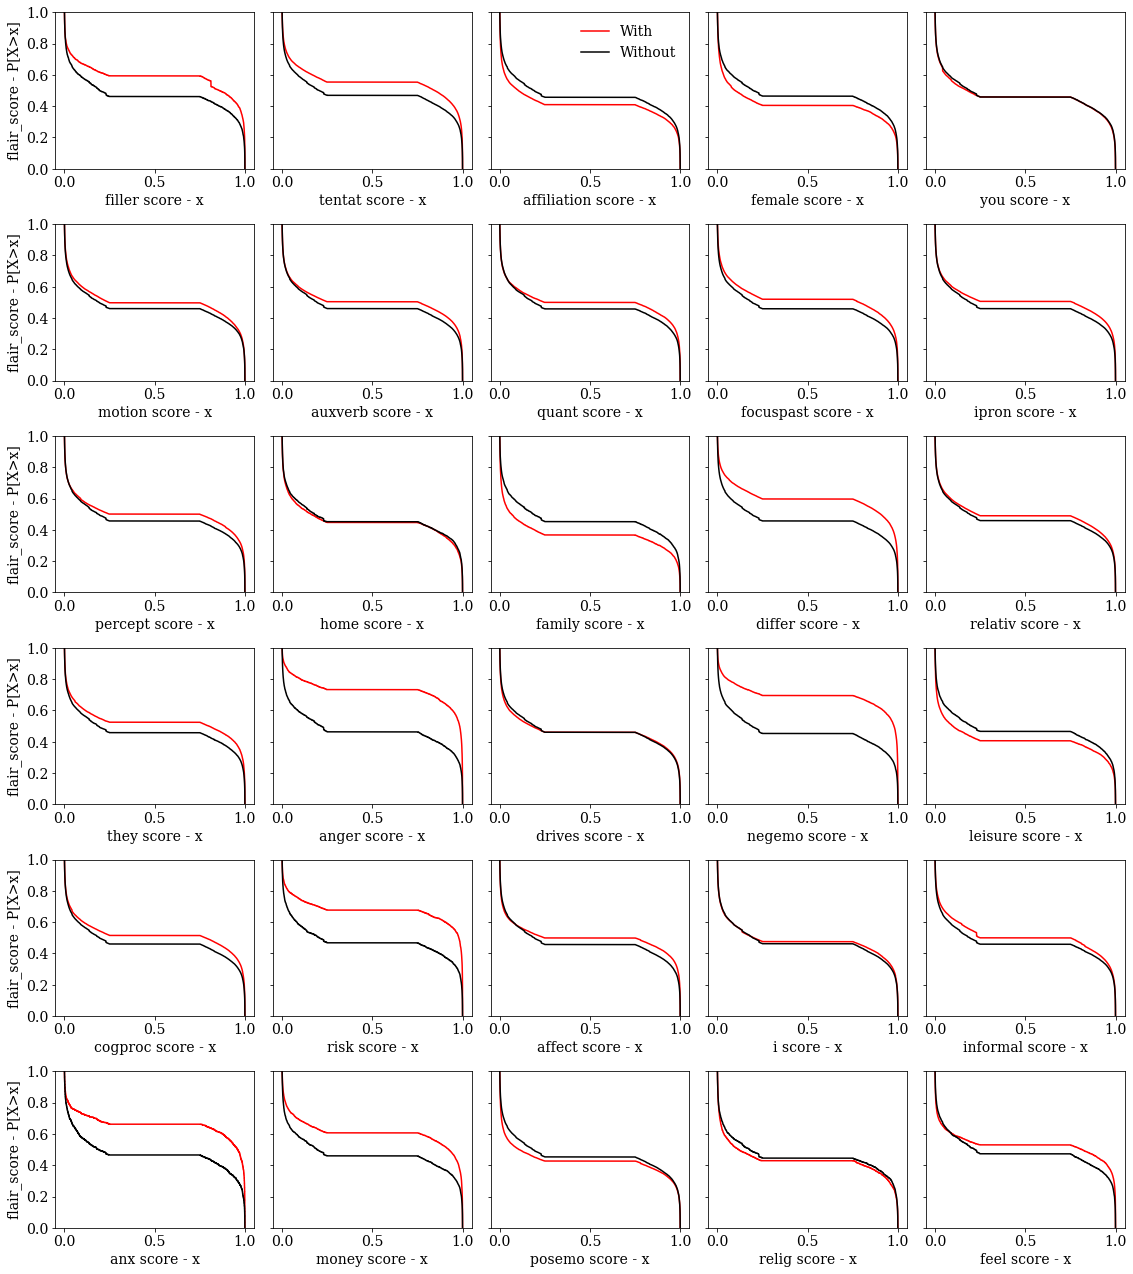

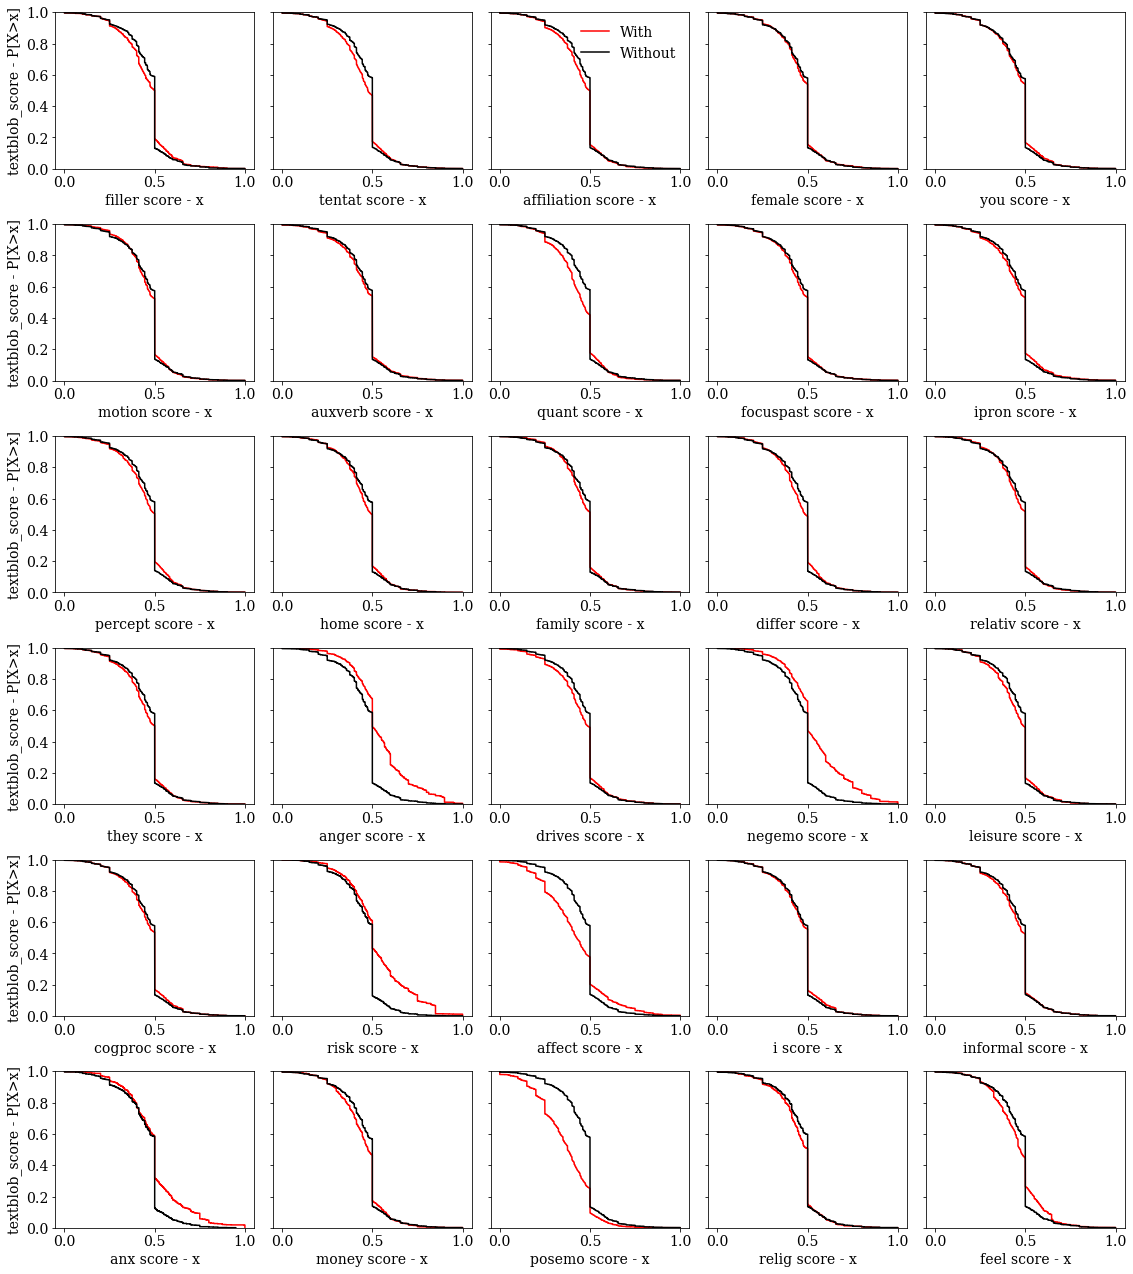

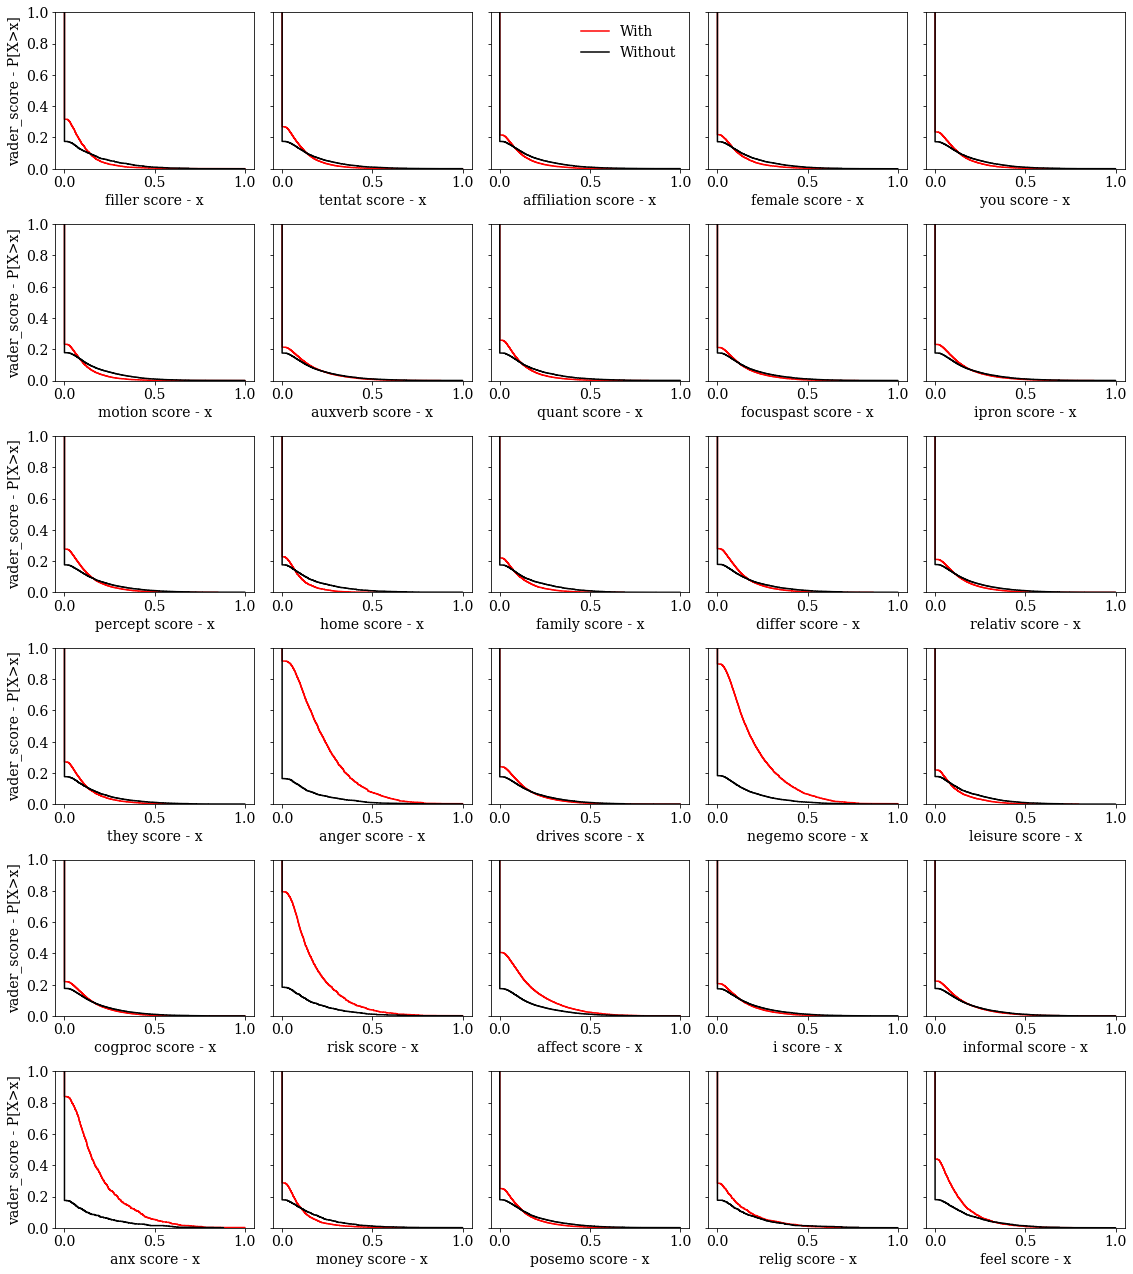

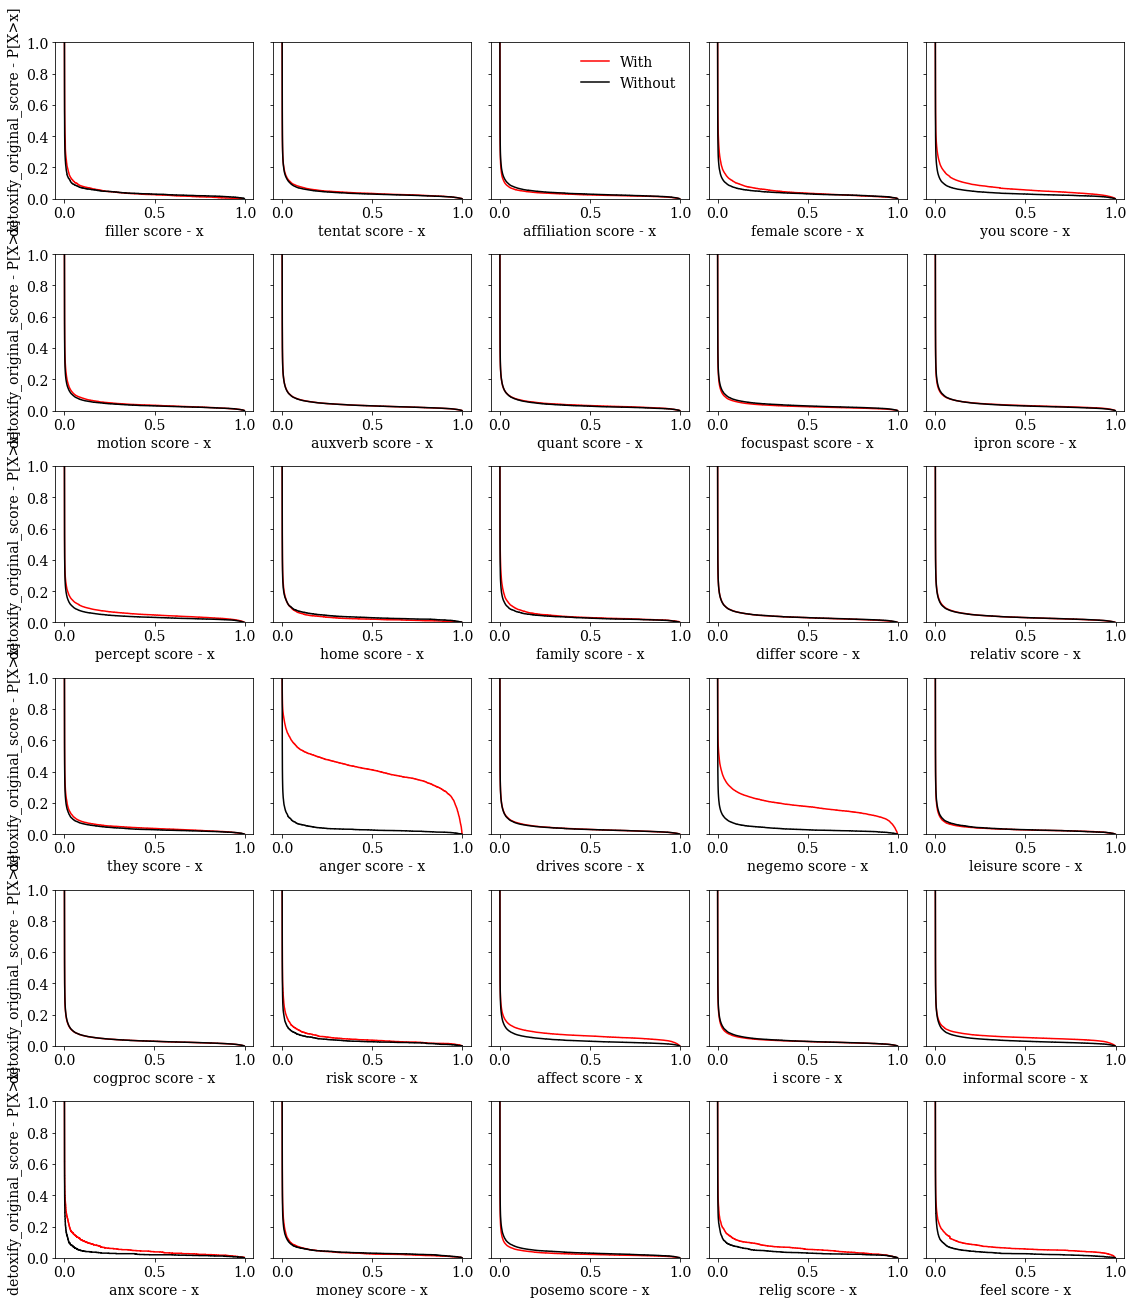

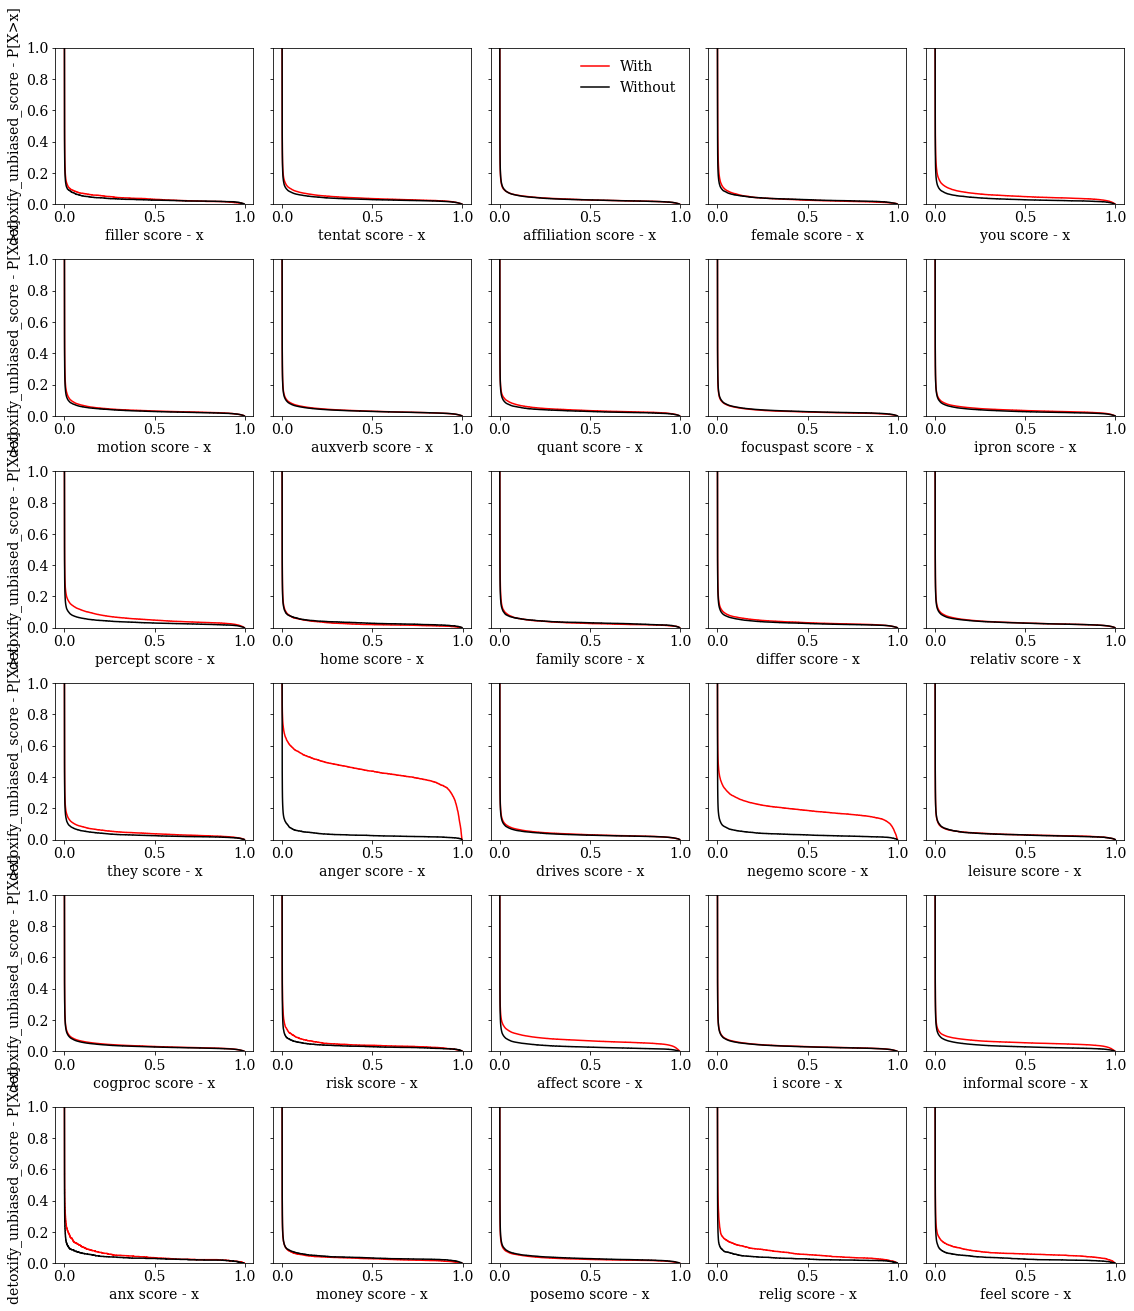

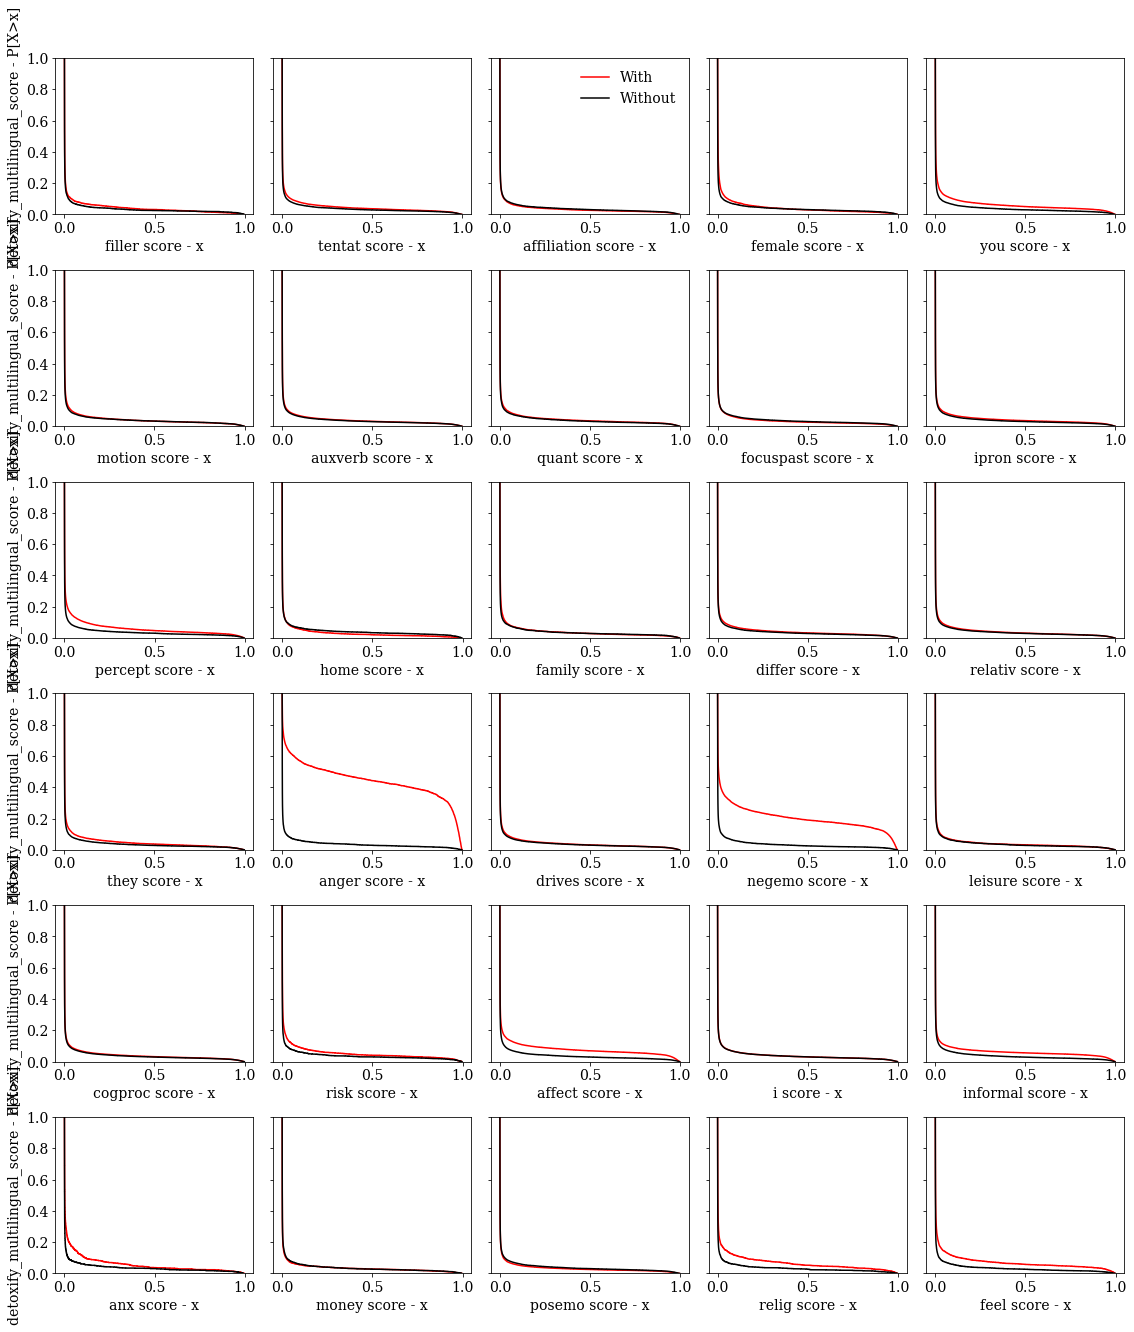

In [68]:
# TODO: nos graficos de score (with e without) usar distribuições com o 
# mesmo numero de sentenças de pretos e brancos, homem e mulher, no momento, 
# nenhuma das formas considera um numero de amostras igual por genero e raça


# analisa i a i de 5 em 5 categorias as categorias que são estatisticamente diferentes obtidas 
# na analise anterior e plota suas frequencias e seus scores
# i = 0
i += 5
ploting_vars = ['filler', 'tentat', 'affiliation', 'female', 'you', 'motion', 'auxverb', 'quant', 'focuspast', 'ipron', 'percept', 'home', 'family', 
'differ', 'relativ', 'they', 'anger', 'drives', 'negemo', 'leisure', 'cogproc', 'risk', 'affect', 'i', 'informal', 'anx','money','posemo','relig', 'friend']
# #list(experiments[experiments.feature.isin(relevant_categories_by_toxicity)].sort_values('pvalue').iloc[i:i+5].feature)

plot_figsize = (16,17.8)
plot_liwc_features(liwc_df_norm,ploting_vars,plot_figsize=plot_figsize)
plot_liwc_scored(scores_liwc,ploting_vars,scores=scores_liwc.columns,comparative_behaviour='same_sz_sample',plot_figsize=plot_figsize)

# categorias interessantes: filler, tentat, affiliation, famale, you, motion, auxverb, quant, focuspast, ipron, percept, home, family, 
# differ, relativ, they, anger, drives, negemo, leisure, cogproc, risk, hear, affect, i, informal, anx, space, money, relig, spcial, sad,
# posemo, see, sexual, cause, friend, power, ingest, focousfuture, body, death, bio, feel

In [66]:
liwc_parser.categories.values()

dict_values(['function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler'])

---

# Avg. words per video

In [54]:
scores_liwc.groupby(['file','group']).sum()[['len']].reset_index().groupby('group').mean()

,len
group,
Black Man,1708.266667
Black Woman,2099.066667
White Man,1467.428115
White Woman,1569.029240
